In [1]:
#imports

import numpy as np
import sys 
import os
import subprocess
sys.path.append("./Python")
sys.path.append("./MMSP")
sys.path.append("C:/Cygwin/bin")
import pf_utils as utils
import pf_init as init
import pf_engine as engine
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
np.set_printoptions(threshold=np.inf)

In [11]:
#initialize the simulation, includes where to save files, the initial step number of zero, and how many steps to simulate per run

data_path = 'plane_snbi_02_d'
tdb_path_2c = 'Ni-Cu_Ideal.tdb'
tdb_path_3c = 'Ni-Cu-Al_Ideal.tdb'
tdb_path_5c = 'Ni-Cu-Al-Pt-Ag_Ideal.tdb'
tdb_path_snbi = 'Sn-Bi.tdb'
step = 0
steps = 500
nbc = [False, False]
init.initializePlaneFront(data_path, tdb_path_snbi, 200, 200, c0=[0.002]) #parameters: x-size, y-size, path to save files. Plane-front always uses [True, False] for nbc
#init.initializeSeeds(data_path, tdb_path_5c, 200, 200, nbc[0], nbc[1], 20) #params: x-size, y-size, Neumann Boundary Conditions (X, Y), number of seeds, path to save files
#init.initializeSeed(data_path, tdb_path_snbi, 200, 200, nbc[0], nbc[1]) #params: x-size, y-size, Neumann Boundary Conditions (X, Y), path to save files
#init.initialize1D(data_path, tdb_path_2c, 80, 20, True, 2, 0.40831, 0.40831)
#init.initialize1D(data_path, tdb_path_3c, 80, 20, True, 3, [0.59169, 0.40831], [0.59169, 0.40831])

A simulation has already been created at this path - aborting initialization!
Please choose a different path, or delete the previous simulation


False

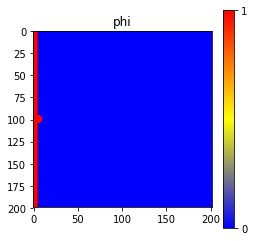

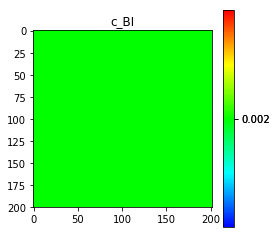

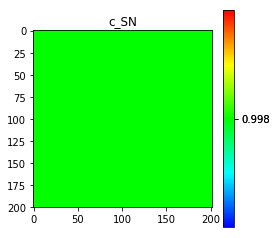

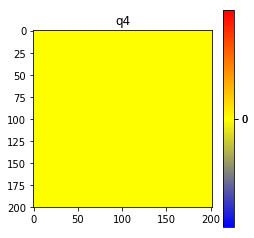

In [12]:
#use this block if 2-component
#step, phi, c, q1, q4 = utils.loadArrays(path, step)
#utils.plotImages(phi, c, q4, nbc, path, step)

#use this block if 3 component
step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step)
utils.plotImages_nc(phi, c, q4, nbc, data_path, step)

0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...

C:\Users\Zhyrek\Anaconda3\envs\m\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...

Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% do

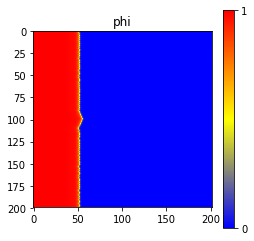

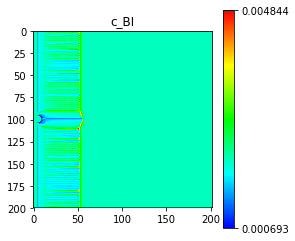

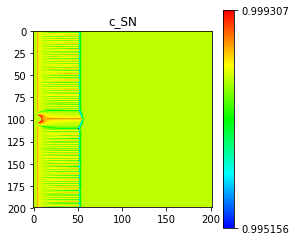

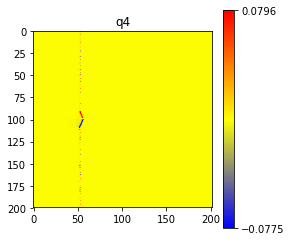

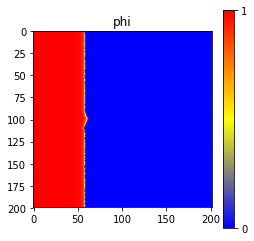

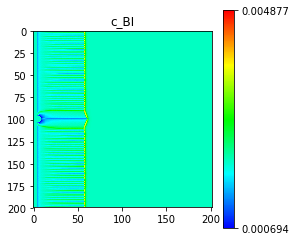

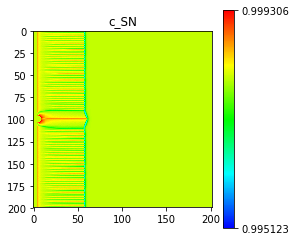

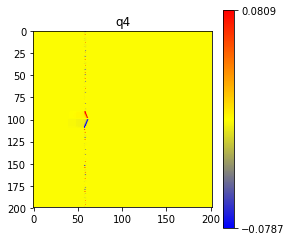

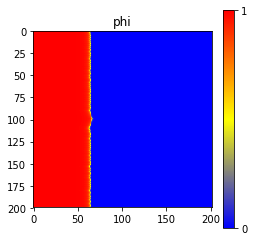

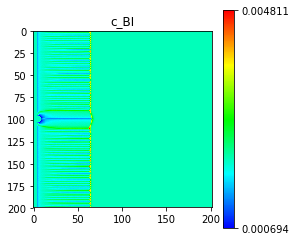

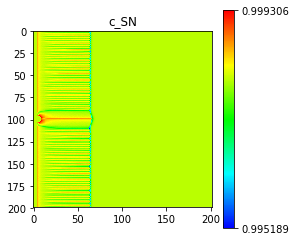

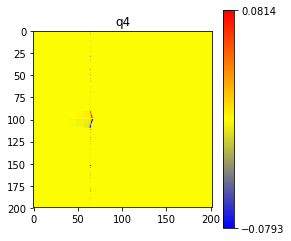

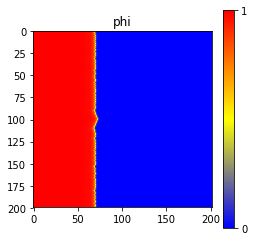

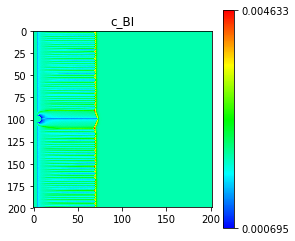

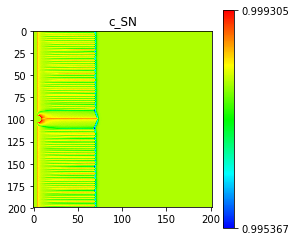

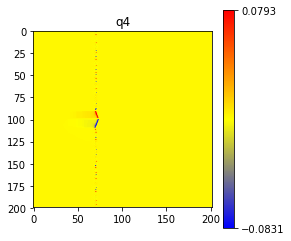

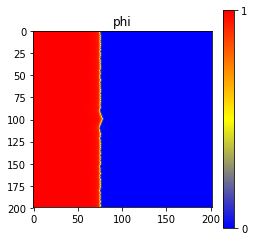

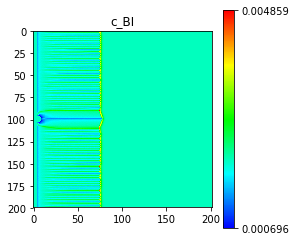

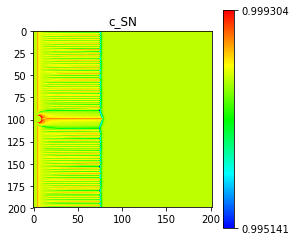

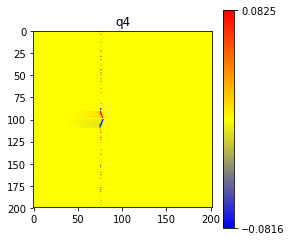

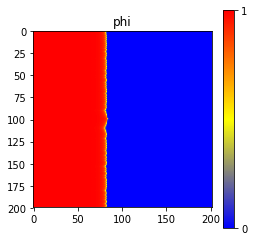

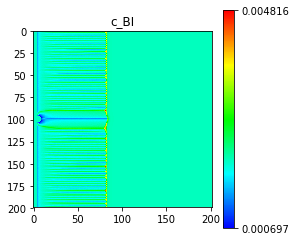

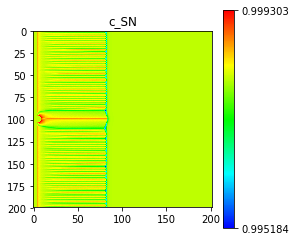

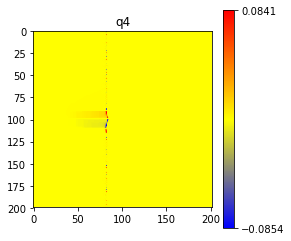

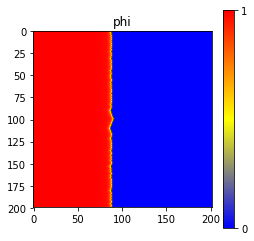

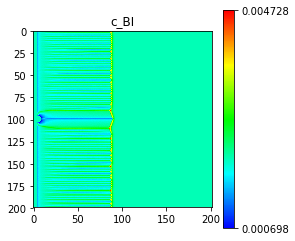

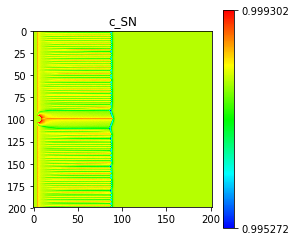

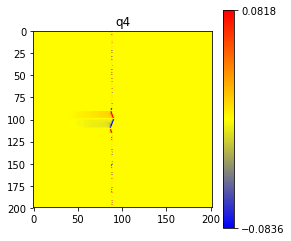

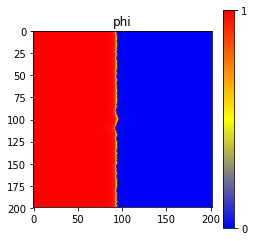

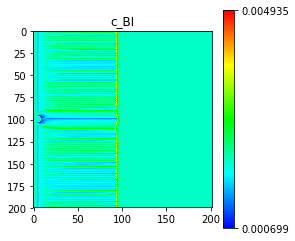

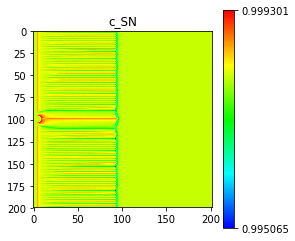

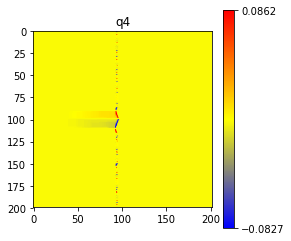

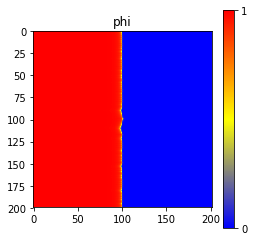

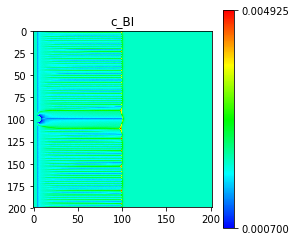

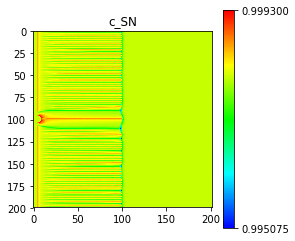

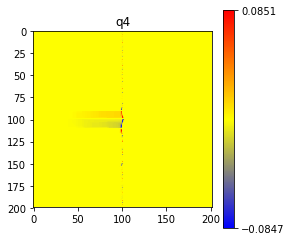

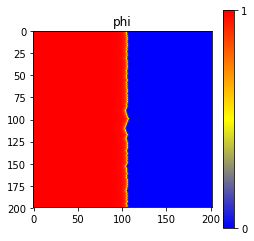

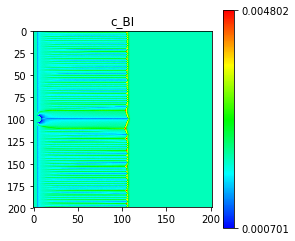

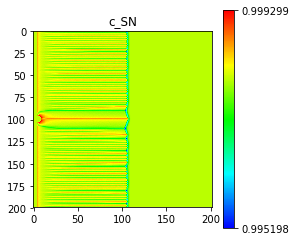

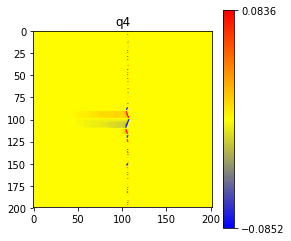

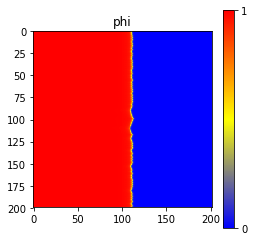

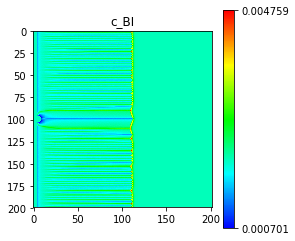

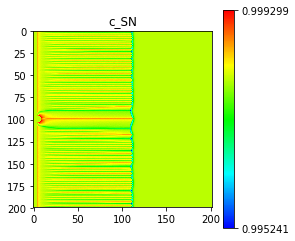

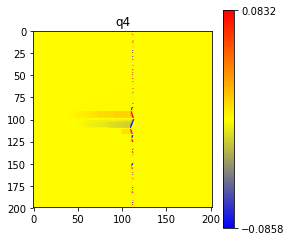

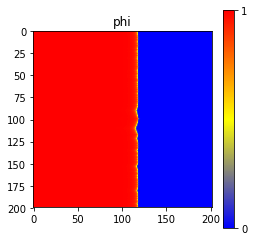

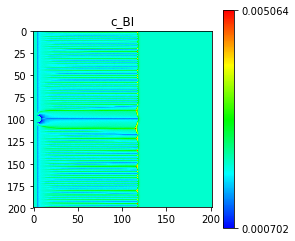

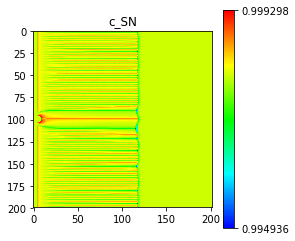

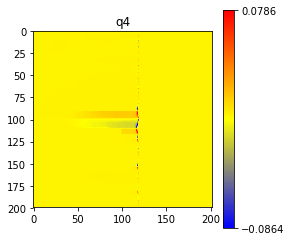

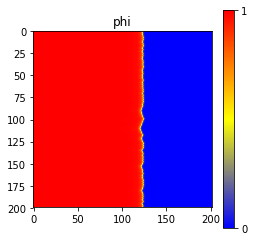

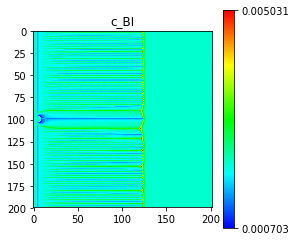

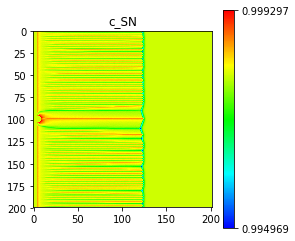

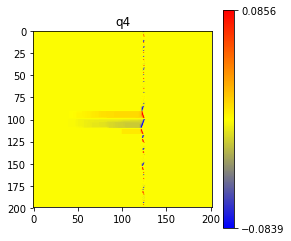

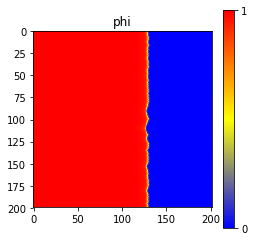

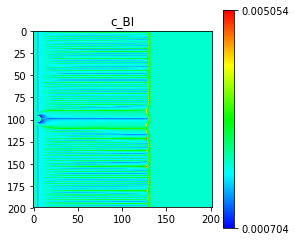

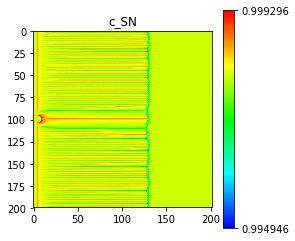

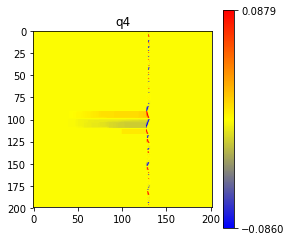

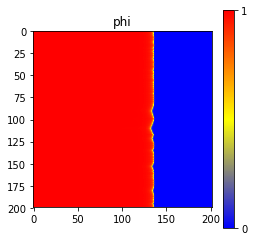

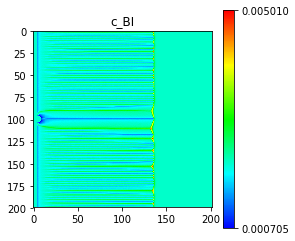

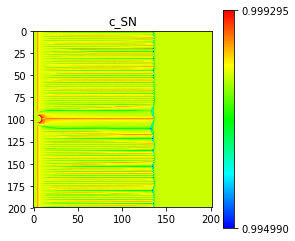

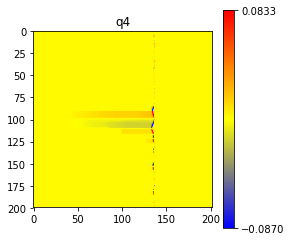

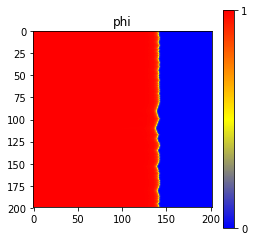

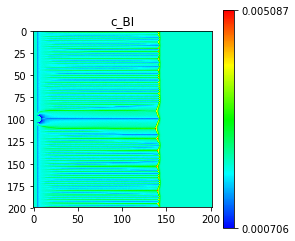

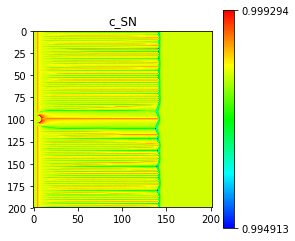

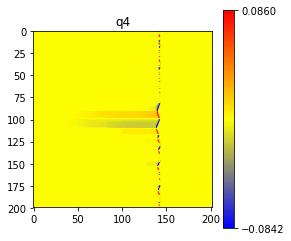

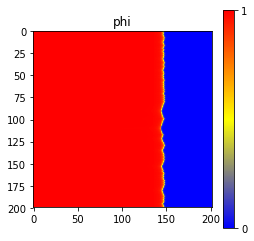

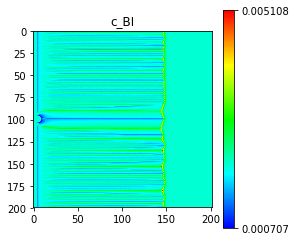

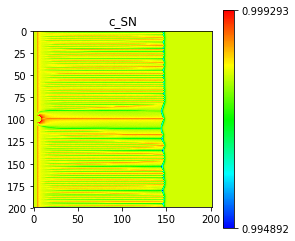

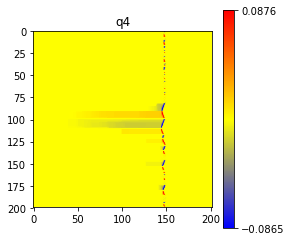

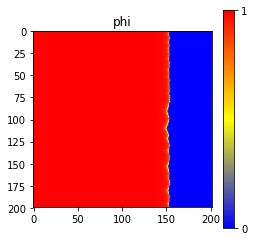

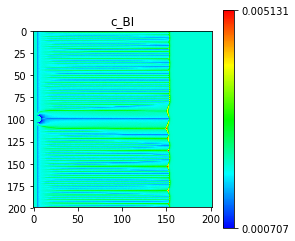

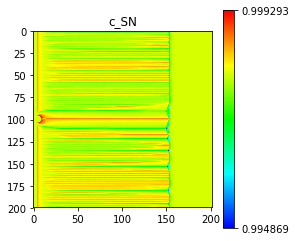

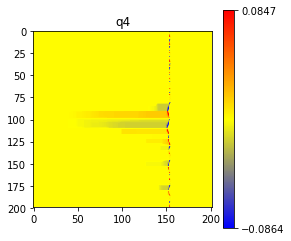

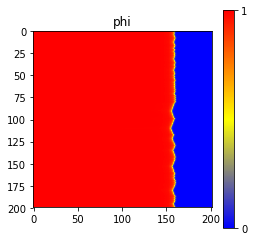

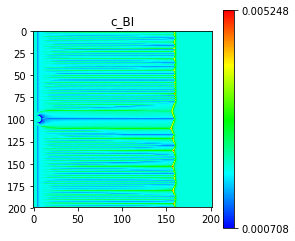

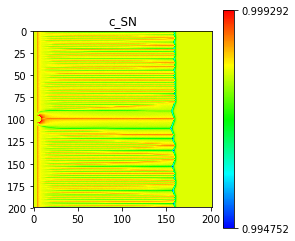

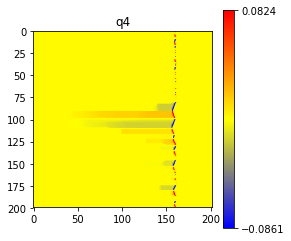

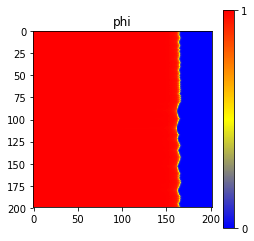

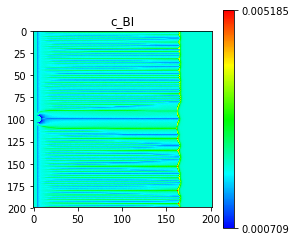

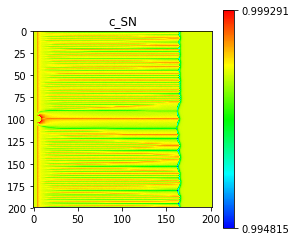

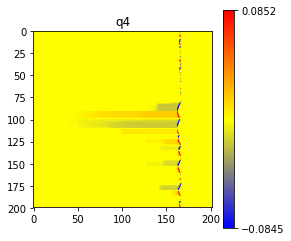

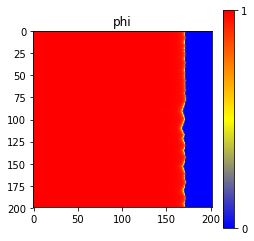

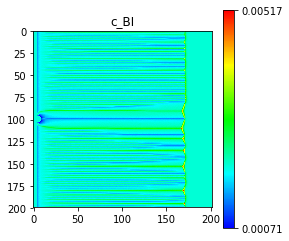

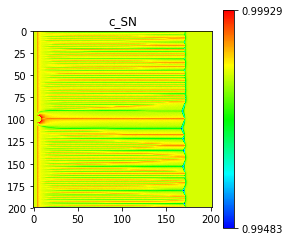

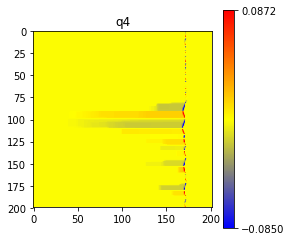

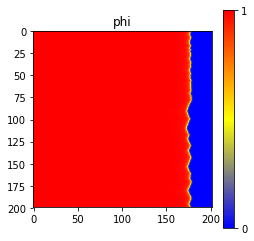

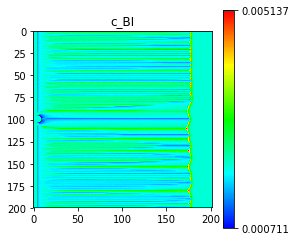

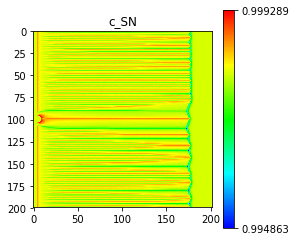

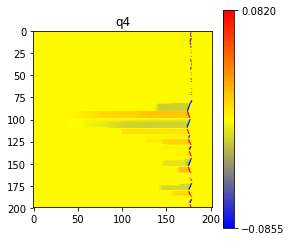

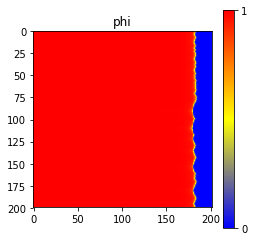

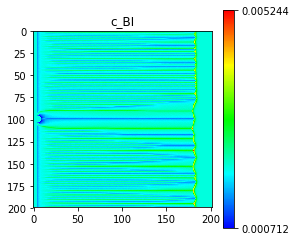

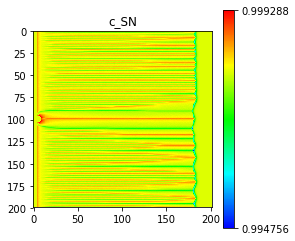

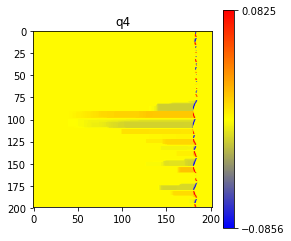

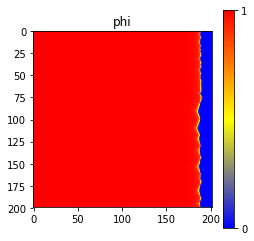

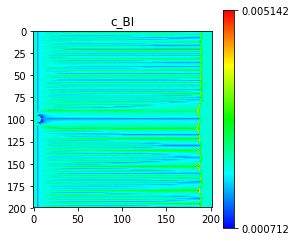

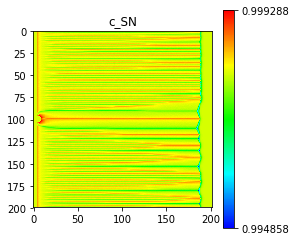

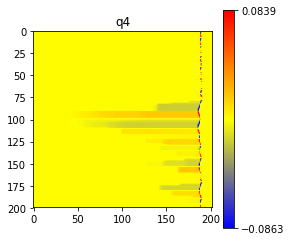

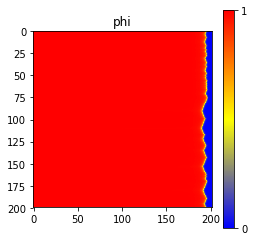

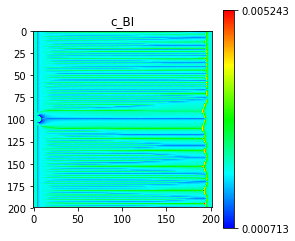

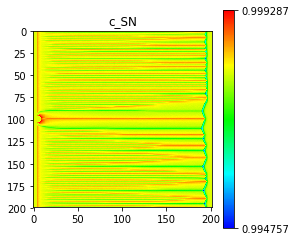

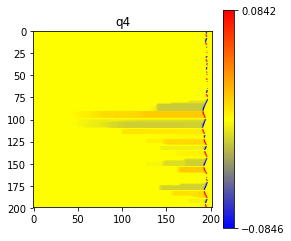

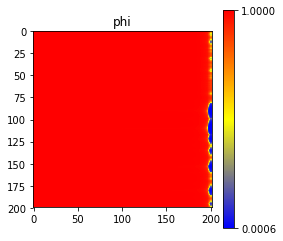

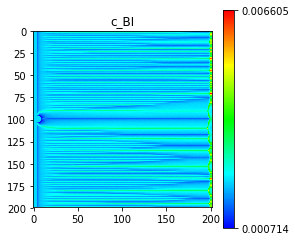

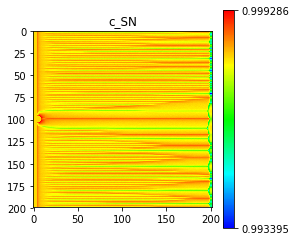

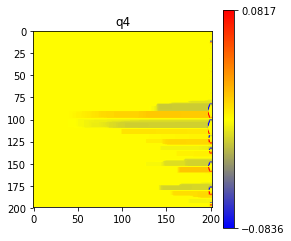

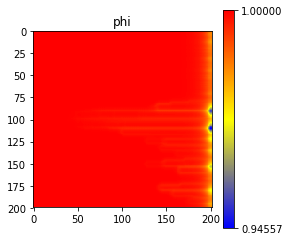

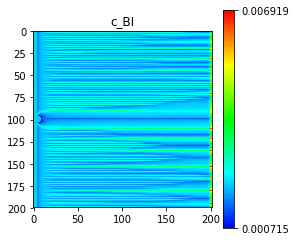

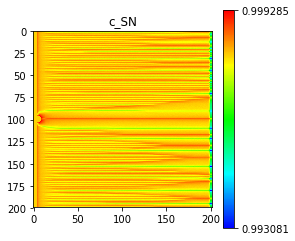

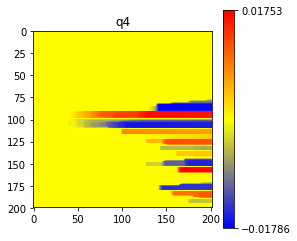

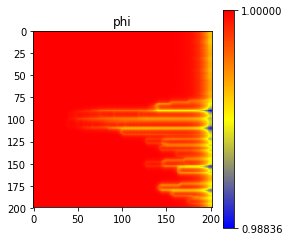

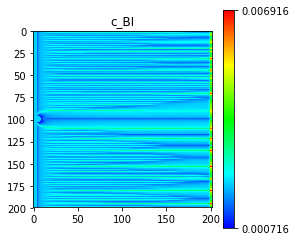

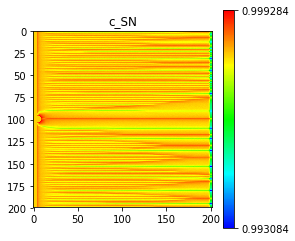

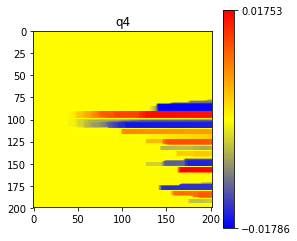

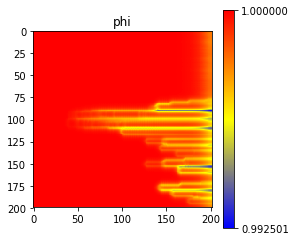

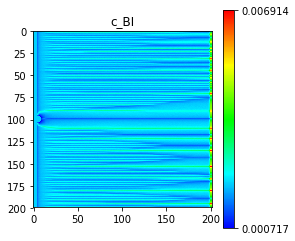

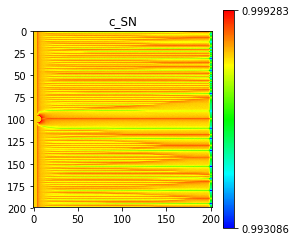

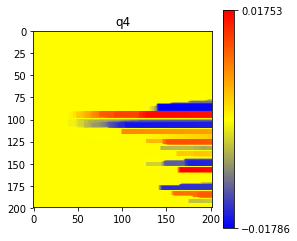

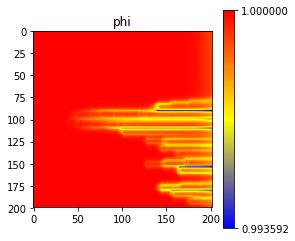

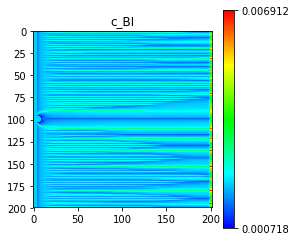

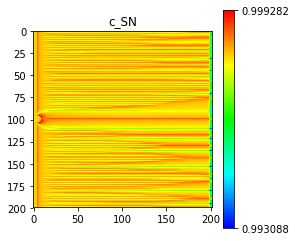

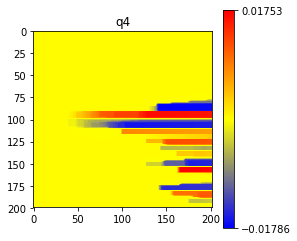

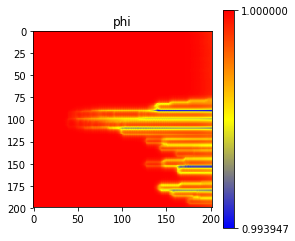

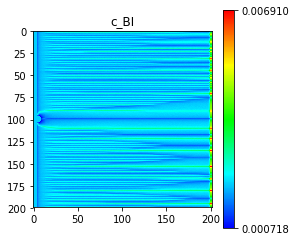

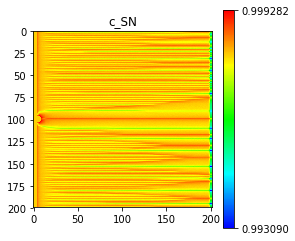

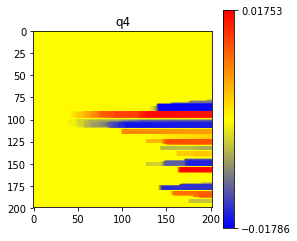

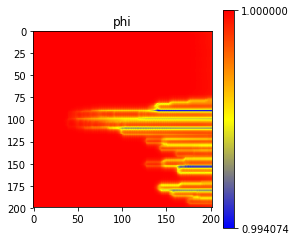

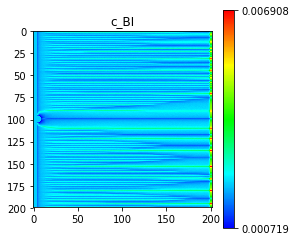

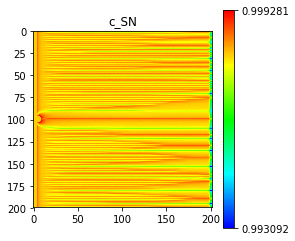

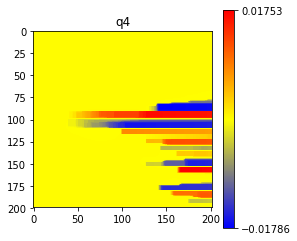

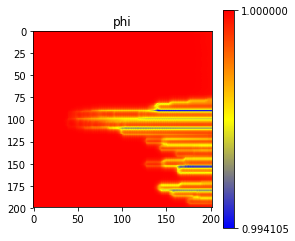

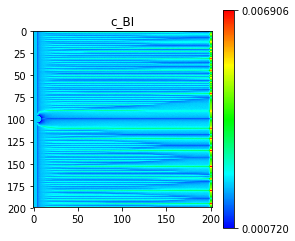

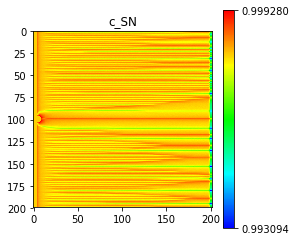

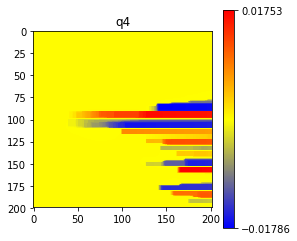

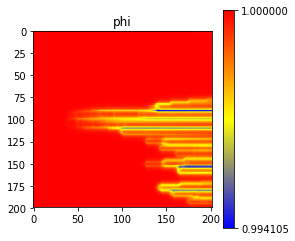

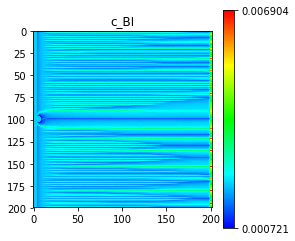

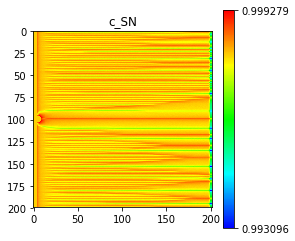

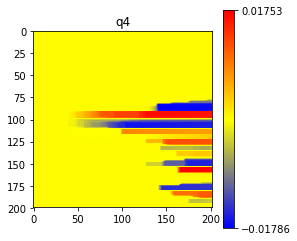

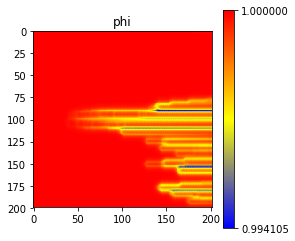

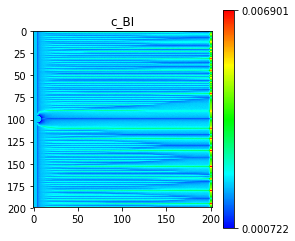

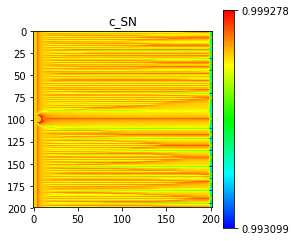

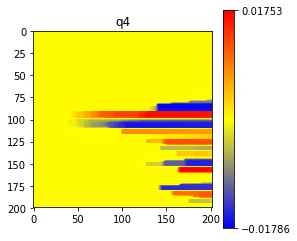

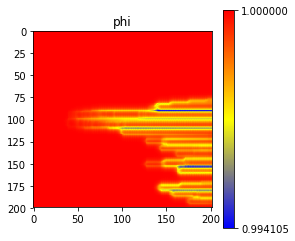

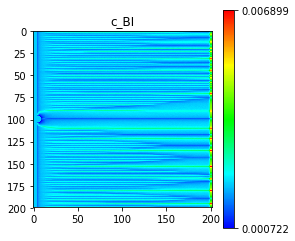

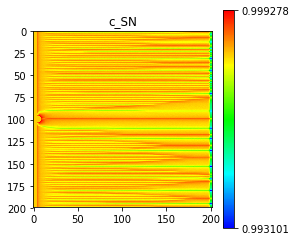

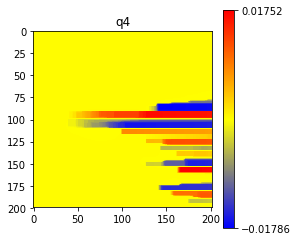

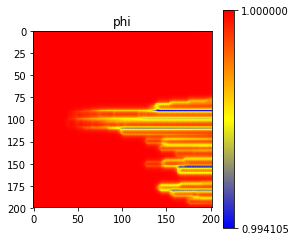

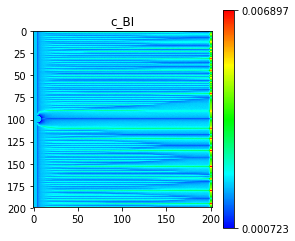

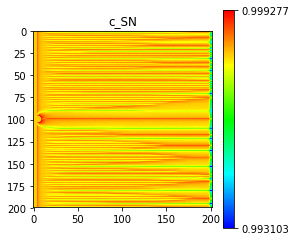

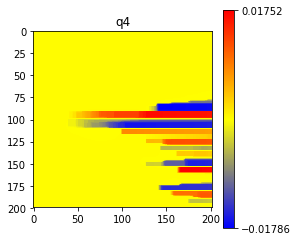

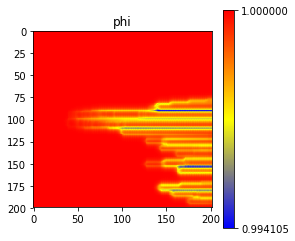

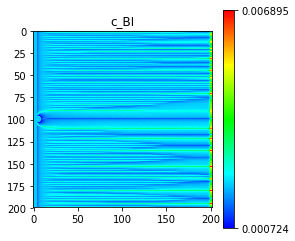

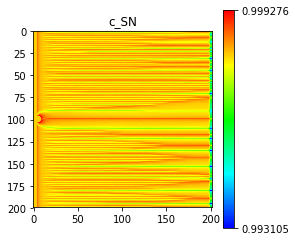

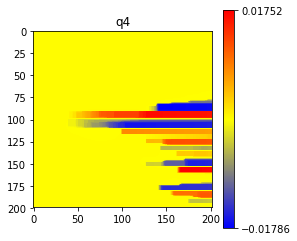

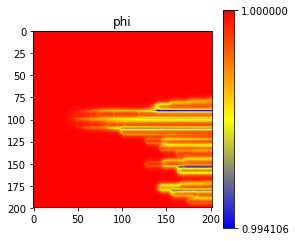

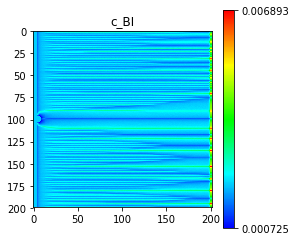

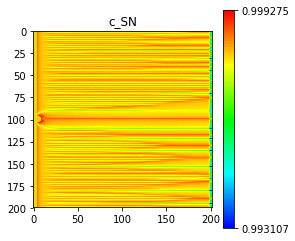

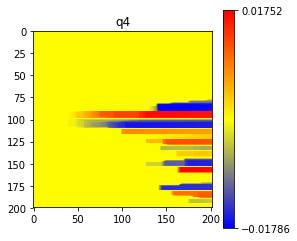

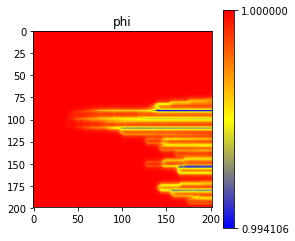

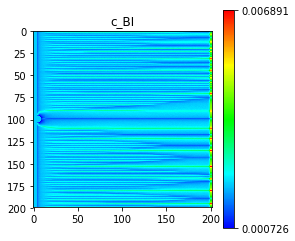

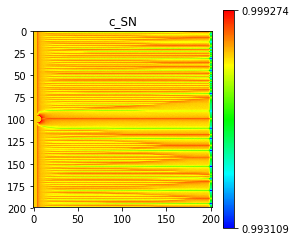

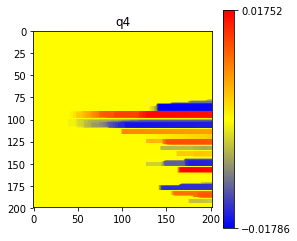

In [14]:
"""
this runs the python engine for the data files selected, then plots the field data as images
"""

for i in range(40): #number of iterations
    #2-component simulation
    #engine.simulate(path, nbc, step, steps, 1574., 0.0, 0.0)
    #step, phi, c, q1, q4 = utils.loadArrays(path, step+steps)
    #utils.plotImages(phi, c, q4, nbc, path, step)
    
    #3-component simulation
    engine.simulate_nc(data_path, step, steps, 480., 0.000036294, -0.000000417381)
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step+steps)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, step)
    


In [ ]:
data_path = 'plane_snbi_02'
tdb_path = 'Sn-Bi.tdb'
step = 0
steps = 500
init.initializePlaneFront(data_path, tdb_path, 50, 50, c0=[0.002])
for i in range(10): #number of iterations
    engine.simulate_nc(data_path, step, steps, 498., 0.00002566373352, -0.0000001475664677)
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step+steps)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, step)
    
step = 0
data_path = 'plane_snbi_04'
init.initializePlaneFront(data_path, tdb_path, 50, 50, c0=[0.004])
for i in range(10): #number of iterations
    engine.simulate_nc(data_path, step, steps, 496., 0.0001312460897, -0.0000007546650155)
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step+steps)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, step)

step = 0
data_path = 'plane_snbi_06'
init.initializePlaneFront(data_path, tdb_path, 50, 50, c0=[0.006])
for i in range(10): #number of iterations
    engine.simulate_nc(data_path, step, steps, 494., 0.000228273868, -0.000001312574741)
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step+steps)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, step)

step = 0
data_path = 'plane_snbi_08'
init.initializePlaneFront(data_path, tdb_path, 50, 50, c0=[0.008])
for i in range(10): #number of iterations
    engine.simulate_nc(data_path, step, steps, 492., 0.0002817155843, -0.00000161986461)
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, step+steps)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, step)

A simulation has already been created at this path - aborting initialization!
Please choose a different path, or delete the previous simulation
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% do

C:\Users\Zhyrek\Anaconda3\envs\m\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...

95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% do

In [ ]:
#this code creates a 3D grid using MMSP
# WARNING - code is proof-of-concept, and may not work on your machine! 
subprocess.Popen(["MMSP/initialize.out", "d:3", "f:MMSP/grid", "o:0.8165,0.3333,0.3333,0.3333", "m:0", "l:25,25,25"])

In [ ]:
#this code runs a 3D grid using MMSP
# WARNING - code is proof-of-concept, and may not work on your machine! 
subprocess.Popen(["MMSP/serial.out", "MMSP/grid", "40", "10"])

# Anisotropic Phase Field Model

This model begins with the following Free Energy functional, similar to Dorr2010 but anisotropic, anisothermal, and allowing for multicomponent.

$$ F = \int_V (\frac{\epsilon_\phi^2\eta T}{2}|\nabla \phi|^2 + f(\phi,c_i) + f_{ori}(\phi, \textbf{q}) + \frac{\epsilon_q^2}{2}|\nabla \textbf{q}|^2 + \lambda (1-\sqrt{\sum q_i^2})) dV$$ 

In order, these terms are:

* The (anisotropic!) interfacial energy in phi
* The bulk free energy
* The orientational energy, representing the energy of lattice mismatch
* The interfacial energy in the orientation (q), artificially added to have smooth orientation transitions
* The Lagrange multiplier term, ensuring the squares of the orientation components sum to 1

We use the following expression to promote cubic symmetry in the PFM:

$$ \eta = 1 - 3\gamma_\epsilon + 4\gamma_\epsilon\frac{\psi_x^4 + \psi_y^4 + \psi_z^4}{|\nabla \phi|^4} $$ 

Here, $\gamma_\epsilon$ represents the magnitude of the anisotropy in the interfacial energy, and all $\psi$ terms are found from rotating the components of $\nabla \phi$ by $\textbf{q}$:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1 + q_2\textbf{i} + q_3\textbf{j} + q_4\textbf{k})*(\phi_x\textbf{i} + \phi_y\textbf{j} + \phi_z\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

It is important to note that, since we are using quaternions, certain multiplications are non-commutative.

$$\textbf{i}\textbf{i} = \textbf{j}\textbf{j} = \textbf{k}\textbf{k} = -1, \textbf{i}\textbf{j} = \textbf{k}, \textbf{j}\textbf{k} = \textbf{i}, \textbf{k}\textbf{i} = \textbf{j}, \textbf{j}\textbf{i} = \textbf{-k}, \textbf{k}\textbf{j} = \textbf{-i}, \textbf{i}\textbf{k} = \textbf{-j}$$

By multiplying out the expression for psi, we may derive equations for them dependent on the various components of $\phi$, and the four quaternion components:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1 + q_2\textbf{i} + q_3\textbf{j} + q_4\textbf{k})*(\phi_x\textbf{i} + \phi_y\textbf{j} + \phi_z\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1\phi_x\textbf{i} + q_1\phi_y\textbf{j} + q_1\phi_z\textbf{k} + q_2\phi_x\textbf{i}\textbf{i} + q_2\phi_y\textbf{i}\textbf{j} + q_2\phi_z\textbf{i}\textbf{k} + q_3\phi_x\textbf{j}\textbf{i} + q_3\phi_y\textbf{j}\textbf{j} + q_3\phi_z\textbf{j}\textbf{k} + q_4\phi_x\textbf{k}\textbf{i} + q_4\phi_y\textbf{k}\textbf{j} + q_4\phi_z\textbf{k}\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1\phi_x\textbf{i} + q_1\phi_y\textbf{j} + q_1\phi_z\textbf{k} - q_2\phi_x + q_2\phi_y\textbf{k} - q_2\phi_z\textbf{j} - q_3\phi_x\textbf{k} - q_3\phi_y + q_3\phi_z\textbf{i} + q_4\phi_x\textbf{j} - q_4\phi_y\textbf{i} - q_4\phi_z)*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = q_1^2\phi_x\textbf{i} + q_1^2\phi_y\textbf{j} + q_1^2\phi_z\textbf{k} - q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} - q_1q_3\phi_x\textbf{k} - q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} - q_1q_4\phi_z - q_1q_2\phi_x\textbf{i}\textbf{i} - q_1q_2\phi_y\textbf{j}\textbf{i} - q_1q_2\phi_z\textbf{k}\textbf{i} + q_2^2\phi_x\textbf{i} - q_2^2\phi_y\textbf{k}\textbf{i} + q_2^2\phi_z\textbf{j}\textbf{i} + q_2q_3\phi_x\textbf{k}\textbf{i} + q_2q_3\phi_y\textbf{i} - q_2q_3\phi_z\textbf{i}\textbf{i} - q_2q_4\phi_x\textbf{j}\textbf{i} + q_2q_4\phi_y\textbf{i}\textbf{i} + q_2q_4\phi_z\textbf{i} - q_1q_3\phi_x\textbf{i}\textbf{j} - q_1q_3\phi_y\textbf{j}\textbf{j} - q_1q_3\phi_z\textbf{k}\textbf{j} + q_2q_3\phi_x\textbf{j} - q_2q_3\phi_y\textbf{k}\textbf{j} + q_2q_3\phi_z\textbf{j}\textbf{j} + q_3^2\phi_x\textbf{k}\textbf{j} + q_3^2\phi_y\textbf{j} - q_3^2\phi_z\textbf{i}\textbf{j} - q_3q_4\phi_x\textbf{j}\textbf{j} + q_3q_4\phi_y\textbf{i}\textbf{j} + q_3q_4\phi_z\textbf{j} - q_1q_4\phi_x\textbf{i}\textbf{k} - q_1q_4\phi_y\textbf{j}\textbf{k} - q_1q_4\phi_z\textbf{k}\textbf{k} + q_2q_4\phi_x\textbf{k} - q_2q_4\phi_y\textbf{k}\textbf{k} + q_2q_4\phi_z\textbf{j}\textbf{k} + q_3q_4\phi_x\textbf{k}\textbf{k} + q_3q_4\phi_y\textbf{k} - q_3q_4\phi_z\textbf{i}\textbf{k} - q_4^2\phi_x\textbf{j}\textbf{k} + q_4^2\phi_y\textbf{i}\textbf{k} + q_4^2\phi_z\textbf{k}$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = q_1^2\phi_x\textbf{i} + q_1^2\phi_y\textbf{j} + q_1^2\phi_z\textbf{k} - q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} - q_1q_3\phi_x\textbf{k} - q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} - q_1q_4\phi_z + q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} + q_2^2\phi_x\textbf{i} - q_2^2\phi_y\textbf{j} - q_2^2\phi_z\textbf{k} + q_2q_3\phi_x\textbf{j} + q_2q_3\phi_y\textbf{i} + q_2q_3\phi_z + q_2q_4\phi_x\textbf{k} - q_2q_4\phi_y + q_2q_4\phi_z\textbf{i} - q_1q_3\phi_x\textbf{k} + q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_2q_3\phi_x\textbf{j} + q_2q_3\phi_y\textbf{i} - q_2q_3\phi_z - q_3^2\phi_x\textbf{i} + q_3^2\phi_y\textbf{j} - q_3^2\phi_z\textbf{k} + q_3q_4\phi_x + q_3q_4\phi_y\textbf{k} + q_3q_4\phi_z\textbf{j} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} + q_1q_4\phi_z + q_2q_4\phi_x\textbf{k} + q_2q_4\phi_y + q_2q_4\phi_z\textbf{i} - q_3q_4\phi_x + q_3q_4\phi_y\textbf{k} + q_3q_4\phi_z\textbf{j} - q_4^2\phi_x\textbf{i} - q_4^2\phi_y\textbf{j} + q_4^2\phi_z\textbf{k}$$

In this expression, every term that does not have a imaginary component (i,j,k) will have a matching, opposite sign term. Therefore, all these terms will cancel out. Then, we group terms based on which component they have:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1^2\phi_x + q_1q_3\phi_z - q_1q_4\phi_y + q_2^2\phi_x + q_2q_3\phi_y + q_2q_4\phi_z + q_1q_3\phi_z + q_2q_3\phi_y - q_3^2\phi_x - q_1q_4\phi_y + q_2q_4\phi_z - q_4^2\phi_x)\textbf{i} + (q_1^2\phi_y - q_1q_2\phi_z + q_1q_4\phi_x - q_1q_2\phi_z - q_2^2\phi_y + q_2q_3\phi_x + q_2q_3\phi_x + q_3^2\phi_y + q_3q_4\phi_z + q_1q_4\phi_x + q_3q_4\phi_z - q_4^2\phi_y)\textbf{j} + (q_1^2\phi_z + q_1q_2\phi_y - q_1q_3\phi_x + q_1q_2\phi_y - q_2^2\phi_z + q_2q_4\phi_x - q_1q_3\phi_x - q_3^2\phi_z + q_3q_4\phi_y + q_2q_4\phi_x + q_3q_4\phi_y + q_4^2\phi_z)\textbf{k}$$

From this equation, we can get the final expression for each of the three psi components:

$$\psi_x = (q_1^2 + q_2^2 - q_3^2 - q_4^2)\phi_x + (2q_2q_3 - 2q_1q_4)\phi_y + (2q_2q_4 + 2q_1q_3)\phi_z$$

$$\psi_y = (2q_2q_3 + 2q_1q_4)\phi_x + (q_1^2 - q_2^2 + q_3^2 - q_4^2)\phi_y + (2q_3q_4 - 2q_1q_2)\phi_z$$

$$\psi_z = (2q_2q_4 - 2q_1q_3)\phi_x + (2q_3q_4 + 2q_1q_2)\phi_y + (q_1^2 - q_2^2 - q_3^2 + q_4^2)\phi_z$$

In 2D, the only meaningful rotation is within the xy plane, so we require that $q_2 = q_3 = 0$ for the 2D model. Additionally, $\phi_z = 0$. As a consequence, the expressions for $\psi$ simplify in the following manner:

$$\psi_x = (q_1^2 - q_4^2)\phi_x - 2q_1q_4\phi_y$$

$$\psi_y = 2q_1q_4\phi_x + (q_1^2 - q_4^2)\phi_y$$

$$\psi_z = 0$$

Returning to the function equation, the bulk free energy, and the orientational mismatch energy are represented by the following equations:

$$ f(\phi, c) = (1-c)(W^Ag(\phi)T + (1-\frac{T}{T_m^A})(e_s^A(T_m^A) - C^AT_m^A + m(\phi)L^A) - C^ATln\frac{T}{T_m^A} + \frac{RT}{v_m}ln(1-c)) + c(W^Bg(\phi)T + (1-\frac{T}{T_m^B})(e_s^B(T_m^B) - C^BT_m^B + m(\phi)L^B) - C^BTln\frac{T}{T_m^B} + \frac{RT}{v_m}ln(c))$$

$$ f_{ori}(\phi, \textbf{q}) = 2HTp(\phi)|\nabla \textbf{q}|$$

These expressions are dependent on several material properties, derived properties, and physical parameters, as well as the three interpolating functions, $g(\phi)$, $m(\phi)$, and $p(\phi)$. Below, descriptions and/or equations are given where appropriate:

* $g(\phi) = \phi^2(1-\phi)^2$
* $m(\phi) = 1 - \phi^3(10-15\phi+6\phi^2)$
* $p(\phi) = \phi^2$
* $T$: Temperature (in Kelvin)
* $T_m^A$, $T_m^B$: Melting temperature of pure material A and B
* $e_s^A(T_X)$, $e_s^B(T_X)$: Internal energies of pure A and B, at some temperature $T_X$
* $C^A$, $C^B$: Heat capacities of pure A and B
* $L^A$, $L^B$: Latent heat of pure A and B
* $R$: Gas constant
* $v_m$: molar volume
* $W^A$: Well height of A, $= \frac{3\sigma^A}{\sqrt{2}T_m^A\delta^A}$
* $W^B$: Well height of B, $= \frac{3\sigma^B}{\sqrt{2}T_m^B\delta^B}$
* $\sigma^A$, $\sigma^B$: Surface energy of pure A and B
* $\delta^A$, $\delta^B$: Interfacial thickness of A and B

We also define the interfacial energy coefficient, $\epsilon_\phi$, using these terms as well:

* $\epsilon_\phi^2 = \frac{6\sqrt{2}\sigma^A\delta^A}{T_m^A} = \frac{6\sqrt{2}\sigma^B\delta^B}{T_m^B}$

In this simulation, A is pure Nickel, and B is pure Copper, with the simulation being treated as an ideal solution. Many of these expressions are taken from Warren1995.

